In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
import pathlib
import matplotlib

sns.set_theme()

green = '#67C478'
purple = '#AAAADD'
blue = '#66CCDD'
orange = '#E89377'

In [41]:
data = pd.DataFrame(columns=['mean', 'median'])
# img_dir = pathlib.Path('/lab/raw-data/220929 BC-EG H4 GBA Substrate/Undyed plate (just substrate)/20x 488 SD stack MIPs/')
# img_dir = pathlib.Path('/fsx/raw-data/220929 BC-EG H4 GBA Substrate/Undyed plate (just substrate)/20x 488 SD one slice /')
img_dir = pathlib.Path('/lab/processed-data/220929 BC-EG H4 GBA Substrate/max_projections/')

img_mean = pd.Series()
img_median = pd.Series()

img_names = img_dir.glob('*488*.tif')
img_names = img_dir.glob('*647*.tif')
for fname in img_names:
    
    img = io.imread(fname, plugin='pil')
    img_mean[fname.name] = img.mean()
    img_median[fname.name] = np.median(img)

data = pd.DataFrame(zip(img_mean, img_median),
                    columns = ['mean', 'median'],
                    index = img_mean.index)

/tmp/ipykernel_3703/2511423881.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  img_mean = pd.Series()
/tmp/ipykernel_3703/2511423881.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  img_median = pd.Series()


Save results

Reformat to plate format

In [44]:
cp_data = pd.read_csv('/lab/processed-data/220929 BC-EG H4 GBA Substrate/2022-11-22_edyta_analysis/2022-11-23_cellpose_cyto2_Image.csv')
cp_data.index = cp_data['FileName_GCase']
cp_data.index = cp_data['FileName_LysoTracker']

cell_count = cp_data.loc[data.index]['Count_cytoplasm_outlines']
cell_count.index = cp_data.loc[data.index]['FileName_GCase']
cell_count.index = cp_data.loc[data.index]['FileName_LysoTracker']

# data['mean'] = np.array(cp_data.loc[data.index]['Mean_cytoplasm_outlines_Intensity_MedianIntensity_LysoTracker'])
# data['mean'] = np.array(cp_data.loc[data.index]['Median_cytoplasm_outlines_Intensity_UpperQuartileIntensity_LysoTracker'])
row_lookup = dict(zip('ABCDEFGH', [0, 1, 2, 3, 4, 5, 6, 7]))
plate = np.zeros((8,12))
plate_cell_count = np.zeros((8,12))
for fname in data.index:
    row = row_lookup[fname[7]]
    col = int(fname[8:10]) - 1
    plate[row, col] = data.loc[fname]['mean']
    plate_cell_count[row, col] = cell_count.loc[fname]

    # row = row_lookup[cell_count.index[i_well][7]]
    # col = int(cell_count.index[i_well][8:10]) - 1
    # plate_cell_count[row, col] = cell_count.iloc[i_well]
    # plate[row, col] = data.loc[fname]['mean']
plate = plate - plate[:,11].mean()
plate = plate / plate_cell_count
baseline = plate[:,10]
baseline.shape = [baseline.shape[0], 1]
plate = plate / baseline
plate = np.delete(plate, [11], axis=1)
# plate = np.concatenate((plate, np.zeros([plate.shape[0],1])), axis=1)

In [38]:
cp_data.columns.tolist()

['Channel_DAPI',
 'Channel_GCase',
 'Channel_LysoTracker',
 'Count_cytoplasm_outlines',
 'ExecutionTime_01Images',
 'ExecutionTime_02Metadata',
 'ExecutionTime_03NamesAndTypes',
 'ExecutionTime_04Groups',
 'ExecutionTime_05HistogramMatching',
 'ExecutionTime_06HistogramMatching',
 'ExecutionTime_07ImageMath',
 'ExecutionTime_08RunCellpose',
 'ExecutionTime_09MeasureColocalization',
 'ExecutionTime_10MeasureObjectIntensity',
 'ExecutionTime_11MeasureObjectIntensityDistribution',
 'ExecutionTime_12MeasureObjectNeighbors',
 'ExecutionTime_13MeasureObjectSizeShape',
 'ExecutionTime_14OverlayOutlines',
 'ExecutionTime_15SaveImages',
 'FileName_DAPI',
 'FileName_GCase',
 'FileName_LysoTracker',
 'FileName_soma_outlines',
 'Frame_DAPI',
 'Frame_GCase',
 'Frame_LysoTracker',
 'Group_Index',
 'Group_Length',
 'Group_Number',
 'Height_DAPI',
 'Height_GCase',
 'Height_LysoTracker',
 'ImageNumber',
 'ImageSet_ImageSet',
 'MD5Digest_DAPI',
 'MD5Digest_GCase',
 'MD5Digest_LysoTracker',
 'Mean_cytopl

In [6]:
plate.shape

(8, 12)

In [8]:
# plate_cell_count = np.delete(plate_cell_count, [11], axis=1)
# plate = plate_cell_count

Calculate means & plot

<Figure size 720x504 with 0 Axes>

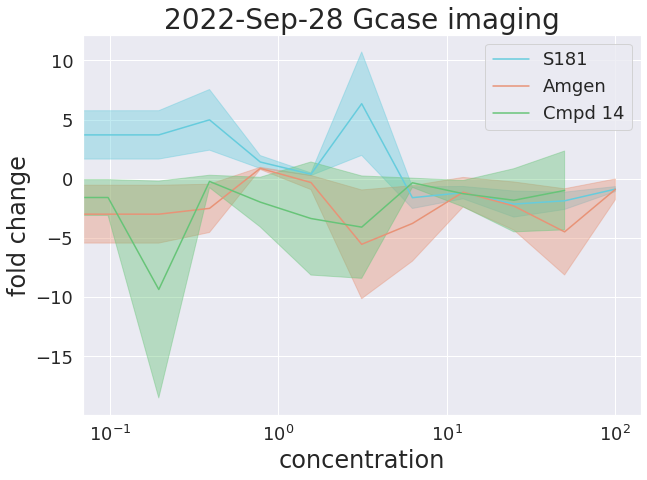

In [45]:
plt.clf()
fig = plt.figure()
plt.rcParams['font.size'] = 52
plt.rcParams['figure.figsize'] = (10, 7)

conditions = dict(zip(['S181', 'Amgen', 'Cmpd 14'], [[0,7], [1, 2, 3], [4, 5, 6]]))
# for key, value in conditions.items():
#     plt.plot(np.zeros(plate[value,:].shape(axis=1)))

row_inds = conditions['S181']
# x = [200, 100, 50, 25,12.5,6.25,3.125,1.5625,0.78125, 0]
x = [100, 50, 25,12.5,6.25,3.125,1.5625,0.78125, 0.390625, 0.1953125, 0]
y = plate[row_inds,:].mean(axis=0)
err = plate[row_inds,:].std(axis=0) / np.sqrt(plate[row_inds,:].shape[0])
plt.fill_between(x, y-err, y+err, color=blue, alpha=0.4, label='_nolegend_')
plt.plot(x, y, color=blue)


row_inds = conditions['Amgen']
x = [100, 50, 25,12.5,6.25,3.125,1.5625,0.78125, 0.390625, 0.1953125, 0]
y = plate[row_inds,:].mean(axis=0)
err = plate[row_inds,:].std(axis=0) / np.sqrt(plate[row_inds,:].shape[0])
plt.fill_between(x, y-err, y+err, color=orange, alpha=0.4, label='_nolegend_')
plt.plot(x, y, color=orange)

row_inds = conditions['Cmpd 14']
x = [50, 25,12.5,6.25,3.125,1.5625,0.78125, 0.390625, 0.1953125, 0.09765625, 0]
y = plate[row_inds,:].mean(axis=0)
err = plate[row_inds,:].std(axis=0) / np.sqrt(plate[row_inds,:].shape[0])
plt.fill_between(x, y-err, y+err, color=green, alpha=0.4, label='_nolegend_')
plt.plot(x, y,  color=green)

ax = plt.gca()
ax.set_xscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('concentration', fontsize=24)
plt.ylabel('fold change', fontsize=24)
plt.title('2022-Sep-28 Gcase imaging', fontsize=28)
plt.legend(conditions.keys(), fontsize = 18)
plt.show()
# fig.savefig('/fsx/processed-data/220929 BC-EG H4 GBA Substrate/Undyed plate (just substrate)/20x 488 SD one slice /2022-11-17_CRC_for_edyta.png', dpi=200)

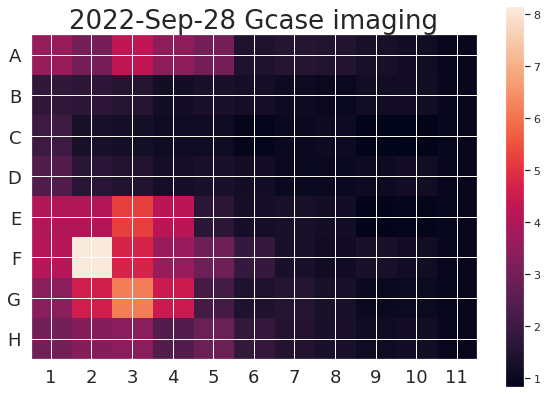

In [12]:
fig = plt.figure()
plt.imshow(plate)
plt.yticks(list(row_lookup.values()), list(row_lookup.keys()), fontsize=18)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10,11], fontsize=18)
plt.title('2022-Sep-28 Gcase imaging', fontsize=26)
plt.colorbar()
# plt.show()
plt.rcParams['font.size'] = '32'
# fig.savefig('/fsx/processed-data/220929 BC-EG H4 GBA Substrate/Undyed plate (just substrate)/20x 488 SD one slice /2022-11-17_plate_heatmap_for_edyta.png', dpi=200)

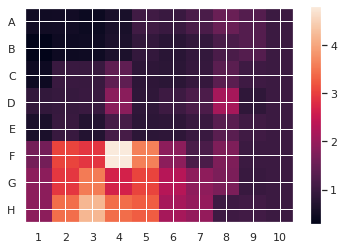

In [4]:
fig = plt.figure()
plt.imshow(plate)
plt.yticks(list(row_lookup.values()), list(row_lookup.keys()))
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10])
plt.colorbar()

In [23]:
p = pd.DataFrame(plate, index=row_lookup.keys(), columns=np.arange(1,plate.shape[1]+1))

In [24]:
p.to_csv('/fsx/processed-data/220929 BC-EG H4 GBA Substrate/Undyed plate (just substrate)/20x 488 SD stack MIPs/2022-11-17_field_measurements_raw.csv')

In [11]:
row_lookup = dict(zip('ABCDEFGH', [0, 1, 2, 3, 4, 5, 6, 7]))
plate = np.zeros((8,12))
for fname in data.index:
    row = row_lookup[fname[13]]
    col = int(fname[14:16]) - 1
    plate[row, col] = data.loc[fname]['mean']
pd.DataFrame(plate)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1012.735263,1022.266632,976.137246,1082.673471,1374.881608,1322.327395,1450.173723,1666.044008,1516.310344,1336.008332,700.248745,687.014605
1,983.461671,1149.315125,1175.013252,1332.918238,1612.949396,1480.586108,1600.678908,1874.499444,1976.381691,1690.559865,695.693505,690.966841
2,1404.259144,2243.627261,2217.904098,2908.603782,2032.212017,1955.691239,2169.290577,2823.672652,2327.016979,2263.401303,695.972512,694.556950
3,1999.981449,2061.772410,2129.803418,3400.575350,1943.890839,2165.404946,2416.823965,3795.038485,1940.959088,2141.081289,707.032593,693.859284
4,1552.896469,2018.204024,1685.905009,2253.219439,1824.735184,1862.768731,2056.755563,2546.806302,2143.500307,2072.243344,702.584450,697.058823
5,2830.586964,4672.528759,4479.245023,6951.558524,5405.408823,3154.360457,2234.401094,2963.775280,2008.658273,1998.989791,705.000560,698.996725
6,3110.028498,4453.183065,5260.038671,4110.784848,4599.598560,3687.909233,3146.418247,2878.876522,1940.177805,1980.313426,713.358012,695.009081
7,3094.744998,5070.462504,6050.698840,5065.634779,4886.830700,3432.774590,3208.139247,2018.641267,2076.485256,1972.249697,692.849718,686.675514
